# Optimal Mean Reversion Trading with Transaction Costs


This Notebook provides code to replicate the optimal timing strategies for trading a mean-reverting price spread as presented in the paper "Optimal Mean Reversion Trading with Transaction Costs and Stop-Loss Exit" by Tim Leung and Xin Li.

(underlying Paper: https://www.worldscientific.com/doi/epdf/10.1142/S021902491550020X)

## Fitting the Ornstein-Uhlenbeck Process

The paper incorporates a standard Orstein-Uhlenbeck (OU) process driven by the following SDE:

$$dX_t=\mu(\theta-X_t)dt+\sigma dB_t$$

where $dW_t$ denotes a Brownian motion with $\mu,\sigma > 0$ and $\theta$ is $\in R$. 

Be aware that $\mu$ and $\theta$ are in this paper used interchanged compared to the standard convention!

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, e, pi, exp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import fsolve
from yahoo_fin import stock_info
from functools import lru_cache

# (!pip install requests_html # package required by yahoo_fin)

The portfolio that will we traded later will be constructed by going long one risky asset A while shorting a different risky asset B. In order to create a Portfolio that exhibits the desired mean reverting properties, the positions sizes $\alpha$ and $\beta$ will be adjusted in order to maximize those. 

The portfolio value X is represented by the following equation:
$$X_t^{\alpha\beta} = \alpha A_t - \beta B_t$$

Parsing through different pairs of $\alpha$ and $\beta$ and using the observed values, we maximize the average log-likelihood defined by the equation:

$$ℓ(\theta,\mu,\sigma|x_0^{\alpha\beta}, x_1^{\alpha\beta}, ...,x_n^{\alpha\beta}) = -\frac{1}{2}ln(2\pi)-ln(\tilde\sigma)-\frac{1}{2n\tilde\sigma^2}\sum\limits _{i=1}^{n}[x_i^{\alpha\beta}-x_{i-1}^{\alpha\beta}e^{-\mu\Delta t}-\theta(1-e^{-\mu\Delta t})]^2   $$
with 
$$\tilde\sigma^2=\sigma^2\frac{1-e^{2\mu\Delta t}}{2\mu}$$




In [23]:
def pullData(ticker, start='08/04/2011', stop='05/19/2012'):
    '''
    Uses the Yahoo Finance API to retrieve daily OHLC price data
    Input: Official ticker symbol
    Output: Array with closing values
    '''
    df = stock_info.get_data(ticker, start, stop)
    array = df["close"].values
    return array

def computeX(assetOne, assetTwo, scaleRatio, A=1):
    '''
    Computes the portfolio value X
    Input: Array with prices for Asset 1, Array with prices for Asset 2,
            ratio steps that determine the possible pairs
    Output: Array with prices of the constructed portfolio
    '''
    alpha = A / assetOne[0]
    beta = (A * scaleRatio) / assetTwo[0]
    X = assetOne * alpha - assetTwo * beta
    return X

def logLikelihood(params, X):
    '''
    Log-likelihood function (as described in equation 2.2 in the paper) which
    will asign a certain likelihood value for a certain set of parameters
    Input: start values for mu, sigma, theta in the form of tuples,
            array with the portfolio prices X
    Output: negated log likelihood (in order to process it with minimize func.)
    '''
    n = len(X)
    mu, sigma, theta = params
    deltaT = 1 / 252
    sigmaTildeSquared = sigma ** 2 * (1 - exp(-2 * mu * deltaT)) / (2 * mu) 
    expTerm = np.exp(-mu * deltaT)
    shiftedX = X[:-1]
    currentX = X[1:]
    SumTerm = np.sum((shiftedX - currentX * expTerm - theta * (1 - expTerm)) ** 2)
    l = -0.5 * log(2 * pi) - log(sqrt(sigmaTildeSquared)) - 1 / (2 * n * sigmaTildeSquared) * SumTerm
    return -l

def computeOUParams(X):
    '''
    Calculates the "optimal" set of Ornstein Uhlenbeck coefficients given the portfolio values
    the result from a given set of portfolio weights alpha and beta
    Input: Portfolio values X
    Output: Optimal OU coefficients, maximization Value (likelihood of a certain set of coefficients) 
    '''
    startParams = [0.1, 0.1, X.mean()]
    bounds = [(0.001, None), (0.001, None), (None, None)]
    result = minimize(logLikelihood, startParams, args=(X,), method='L-BFGS-B', bounds=bounds)
    optimizedParams = result.x
    maximizationValue = -result.fun
    return optimizedParams, maximizationValue

def analyzeOUParams(assetOne, assetTwo, portfolioSpreads):
    '''
    Calculates and gathers optimal results for a range of portfolio weights
    Input: Array with prices for Asset 1, Array with prices for Asset 2,
            ratio steps that determine the possible pairs
    Output: DataFrame with optimal values for each set of weights
    '''
    results = pd.DataFrame(columns = ["Spread", "Max", "my", "sigma", "theta"])
    for spreadParam in portfolioSpreads:
        X = computeX(assetOne, assetTwo, spreadParam)
        optimizedOUParams, maximizationResult = computeOUParams(X)
        newRow = pd.DataFrame([[spreadParam, maximizationResult, 
                                 optimizedOUParams[0], optimizedOUParams[1], optimizedOUParams[2]]], 
                               columns=["Spread", "Max", "my", "sigma", "theta"])
        results = pd.concat([results, newRow], ignore_index=True, sort=False)
    return results

In accordance with the process outlined in the research paper, the analysis will use daily price data from August 2011 to May 2012 of the following ETFs:

    - VanEck Gold Miners ETF (GDX)
    - iShares Silver Trust (SLV)
    - SPDR Gold Trust (GLD)

In [24]:
tickers = ["GDX", "SLV", "GLD"]
data = {}

for ticker in tickers:
    data[ticker] = pullData(ticker)

# The portfolio Spreads below will simulate 1000 portfolios with different weights for the respective Securities
portfolioSpreads = np.linspace(.001, 1, 1000)

# Calculation of the OU Coefficients given the 1000 portfolio weights
resultsGLD_GDX = analyzeOUParams(data["GLD"], data["GDX"], portfolioSpreads)
resultsGLD_SLV = analyzeOUParams(data["GLD"], data["SLV"], portfolioSpreads)

# Selection of the portfolio which exhibits the highest log-likelihood (max log-likelihood portfolio)
optimalGLD_GDX = resultsGLD_GDX.loc[resultsGLD_GDX['Max'].idxmax()]
optimalGLD_SLV = resultsGLD_SLV.loc[resultsGLD_SLV['Max'].idxmax()]

# Computation of the portfolio values X of the max log-likelihood portfolio
X_GLD_GDX = computeX(data["GLD"], data["GDX"], optimalGLD_GDX[0])
X_GLD_SLV = computeX(data["GLD"], data["SLV"], optimalGLD_SLV[0])

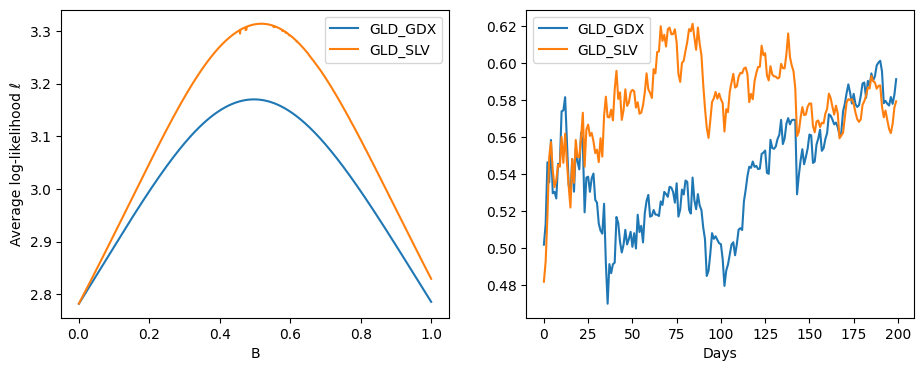

In [25]:
# LEFT: Visualization of the relationship between the portfolio composition and the average log-likelihood
# RIGHT: Visualization of the portfolio values of the max log-likelihood portfolio over time
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plt.plot(resultsGLD_GDX["Spread"], resultsGLD_GDX["Max"],  label="GLD_GDX")
plt.plot(resultsGLD_GDX["Spread"], resultsGLD_SLV["Max"], label="GLD_SLV")
plt.xlabel("B")
plt.ylabel("Average log-likelihood ℓ")
plt.legend() 

plt.subplot(1, 2, 2)
plt.plot(X_GLD_GDX,  label="GLD_GDX")
plt.plot(X_GLD_SLV,  label="GLD_SLV")
plt.xlabel("Days")
plt.legend() 

plt.subplots_adjust(wspace=0.2)
plt.show()

## Solving Optimal Stopping Problem

Using the process parameters $\mu,\sigma$ and $\theta$ of the defined OU Process we further add r and c which represent the set of discount rates and transaction costs.

The Analytical results of optimal sell(b) and buy point(d) can be obtained by solving:

$$F(b) = (b-c)F(b)$$

$$\hat G(d)(V´(d)-1)=\hat G´(d) (V(d) - d - c)$$


To do so we need the following functions outlined in the paper as well as its derivatives:

$$F(x,r) = \int\limits_{0}^{oo}u^{\frac{r}{\mu}-1}e^{\sqrt{\frac{2\mu}{\sigma^2}}(x-\theta)u-\frac{u^2}{2}}du$$
$$G(x,r) = \int\limits_{0}^{oo}u^{\frac{r}{\mu}-1}e^{\sqrt{\frac{2\mu}{\sigma^2}}(\theta-x)u-\frac{u^2}{2}}du$$
$$V(x) = \left\{ \begin{array}{ll}
     (b-c)\frac{F(x)}{F(b)} & \mbox{if $x \in (-\inf,0)$};\\
         x-c & \mbox{otherwise}.\end{array} \right.$$


In [5]:
import sympy as smp
from sympy import *

class OptimalStopping:
    '''
    Provides the optimal entry d and optimal exit b
    '''
    def __init__(self, my, sigma, theta, r, c):
        self.my = my
        self.sigma = sigma
        self.theta = theta
        self.r = r
        self.c = c
        self.u_symbol, self.x_symbol = smp.symbols("u x", real=True)
        self.integrandF = self.u_symbol ** (self.r / self.my - 1) * smp.exp((smp.sqrt(2 * self.my / self.sigma**2) * (self.x_symbol - self.theta) * self.u_symbol - self.u_symbol**2 / 2))
        self.integrandG = self.u_symbol ** (self.r / self.my - 1) * smp.exp((smp.sqrt(2 * self.my / self.sigma**2) * (self.theta - self.x_symbol) * self.u_symbol - self.u_symbol**2 / 2))
        self.derivativeF = smp.diff(self.integrandF, self.x_symbol)
        self.derivativeG = smp.diff(self.integrandG, self.x_symbol)
    
    @lru_cache(maxsize=None)
    def F(self, x):
        '''
        Function F (3.3)
        '''
        return complex(smp.integrate(self.integrandF.subs(self.x_symbol, x), (self.u_symbol, 0, smp.oo)).evalf()).real

    @lru_cache(maxsize=None)
    def f(self, x):
        '''
        Derivative of function F
        '''
        return complex(smp.integrate(self.derivativeF.subs(self.x_symbol, x), (self.u_symbol, 0, smp.oo)).evalf()).real

    def G(self, x):
        '''
        Function G (3.4)
        '''
        return complex(smp.integrate(self.integrandG.subs(self.x_symbol, x), (self.u_symbol, 0, smp.oo)).evalf()).real
    
    def g(self, x):
        '''
        Derivative of function G
        '''
        return complex(smp.integrate(self.derivativeG.subs(self.x_symbol, x), (self.u_symbol, 0, smp.oo)).evalf()).real
    
    def b(self):
        '''
        Optimal Liquidation Level b (4.3)
        '''
        def optFunction(b):
            return float(abs(self.F(b) - (b - self.c) * self.f(b)))
        result = minimize_scalar(optFunction, bounds=(0, 1), method='bounded')
        return result.x
    
    def V(self, x):
        '''
        Function V (4.2)
        '''
        if x < self.b():
            return (self.b() - self.c) * (self.F(x) / self.F(self.b()))
        else:
            return (x - self.c)
     
    def v(self, x):
        '''
        Derivative of function V
        '''
        if x < self.b():
            return (self.b() - self.c) * (self.f(x) / self.F(self.b()))
        else:
            return (1)
    
    def d(self):
        '''
        Optimal Entry Level d (4.11)
        '''
        def optFunction(d):
            return float(abs(self.G(d) * (self.v(d) - 1) - (self.g(d) * (self.V(d) - d - self.c))))
        upperBound = self.b()
        result = minimize_scalar(optFunction, bounds=(0, upperBound), method='bounded')
        return result.x

In [18]:
# Definition of two instances of class Optimal Stopping
# Calculation of the respective optimal liquidation and entry levels b and d
r, c = 0.1, 0.005

opt_GLD_GDX = OptimalStopping(optimalGLD_GDX[2], optimalGLD_GDX[3], optimalGLD_GDX[4], r, c)
b_GLD_GDX = opt_GLD_GDX.b()
d_GLD_GDX = opt_GLD_GDX.d()

opt_GLD_SLV = OptimalStopping(optimalGLD_SLV[2], optimalGLD_SLV[3], optimalGLD_SLV[4], r, c)
b_GLD_SLV = opt_GLD_SLV.b()
d_GLD_SLV = opt_GLD_SLV.d()

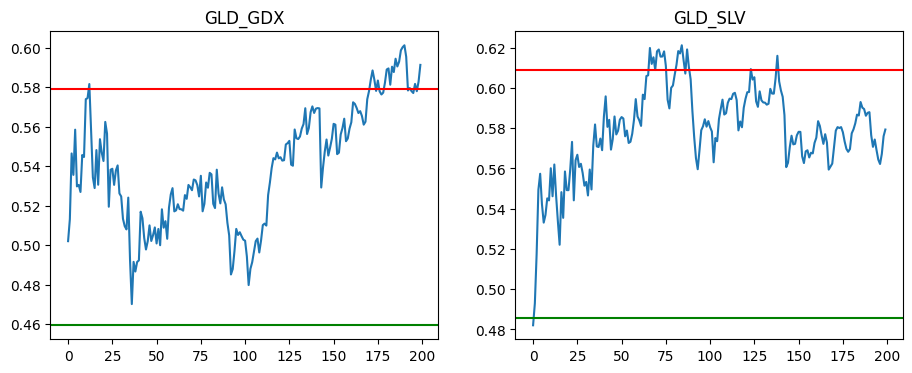

In [27]:
# Visualization of the price movement of the two portfolios as well as the optimal 
# liquidaiton and entry levels.
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plt.title("GLD_GDX")
plt.plot(X_GLD_GDX,  label="GLD_GDX")
plt.axhline(y=b_GLD_GDX, color="r")
plt.axhline(y=d_GLD_GDX, color="g")

plt.subplot(1, 2, 2)
plt.title("GLD_SLV")
plt.plot(X_GLD_SLV,  label="GLD_SLV")
plt.axhline(y=b_GLD_SLV, color="r")
plt.axhline(y=d_GLD_SLV, color="g")

plt.subplots_adjust(wspace=0.2)

plt.show()